In [32]:
import keras
from keras.models import Sequential,load_model
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [34]:
img_dir = 'binary_mm/crop_mm'
df=pd.read_csv('binary_mm/crop_mm_relabel.csv')
# label needs to be string if class_mode is binary
df = df.applymap(str)
columns=df.columns.tolist()[4]
columns

'badsurface'

In [35]:
df.head()

,External ID,partialm,offcenterm,badshape,badsurface
0,IMG756.jpg,0,0,0,0
1,IMG20.jpg,0,0,1,1
2,IMG788.jpg,0,0,0,0
3,IMG52.jpg,0,0,1,1
4,IMG820.jpg,1,0,0,0


In [37]:
image_size = 100
batch_size = 64

In [38]:
datagen=ImageDataGenerator(rescale=1./255.)
test_datagen=ImageDataGenerator(rescale=1./255.)

train_generator=datagen.flow_from_dataframe(
dataframe=df[:1069],
directory=img_dir,
x_col="External ID",
y_col=columns,
batch_size=batch_size,
seed=42,
shuffle=True,
class_mode="binary",
target_size=(image_size,image_size))

Found 1069 images belonging to 2 classes.


In [39]:
valid_generator=test_datagen.flow_from_dataframe(
dataframe=df[1069:1203],
directory=img_dir,
x_col="External ID",
y_col=columns,
batch_size=batch_size,
seed=42,
shuffle=True,
class_mode="binary",
target_size=(image_size,image_size))

Found 134 images belonging to 2 classes.


In [40]:
test_generator=test_datagen.flow_from_dataframe(
dataframe=df[1203:],
directory=img_dir,
x_col="External ID",
y_col=columns,
batch_size=1,
seed=42,
shuffle=False,
class_mode="binary",
target_size=(image_size,image_size))

Found 133 images belonging to 2 classes.


In [42]:
# original model
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',input_shape=(image_size,image_size,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizers.rmsprop(lr=0.0001, decay=1e-6),loss="binary_crossentropy",metrics=["accuracy"])

In [25]:
# DLP model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu',
                        input_shape=(image_size, image_size, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizers.rmsprop(lr=0.0001, decay=1e-6),loss="binary_crossentropy",metrics=["accuracy"])

In [26]:
# DLP model with dropout
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu',
                        input_shape=(image_size, image_size, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizers.rmsprop(lr=0.0001, decay=1e-6),loss="binary_crossentropy",metrics=["accuracy"])

In [68]:
# model = load_model('.h5')

In [43]:
mkdir 'my_log_dir/'

mkdir: cannot create directory ‘my_log_dir/’: File exists


In [54]:
callbacks_list = [
keras.callbacks.EarlyStopping(
monitor='acc',
patience=10,
),
keras.callbacks.ModelCheckpoint(
filepath='binary_mm_badshape.h5',
monitor='val_loss',
save_best_only=True,
),
keras.callbacks.ReduceLROnPlateau(
monitor='val_loss',
factor=0.1,
patience=10,
),
keras.callbacks.TensorBoard(
log_dir='my_log_dir',
histogram_freq=0, write_graph=True,
)
]

In [55]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

history = model.fit_generator(
                    generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=30,
                    callbacks=callbacks_list,
)

Epoch 1/30
16/16 [==============================] - 34s 2s/step - loss: 0.6636 - acc: 0.6283 - val_loss: 0.5296 - val_acc: 0.8429
Epoch 2/30
16/16 [==============================] - 34s 2s/step - loss: 0.6453 - acc: 0.6518 - val_loss: 0.5267 - val_acc: 0.8672
Epoch 3/30
16/16 [==============================] - 34s 2s/step - loss: 0.6338 - acc: 0.6557 - val_loss: 0.4865 - val_acc: 0.8286
Epoch 4/30
16/16 [==============================] - 34s 2s/step - loss: 0.6047 - acc: 0.6917 - val_loss: 0.4728 - val_acc: 0.8857
Epoch 5/30
16/16 [==============================] - 34s 2s/step - loss: 0.5955 - acc: 0.7028 - val_loss: 0.4133 - val_acc: 0.9062
Epoch 6/30
16/16 [==============================] - 34s 2s/step - loss: 0.5759 - acc: 0.7120 - val_loss: 0.4644 - val_acc: 0.8571
Epoch 7/30
16/16 [==============================] - 33s 2s/step - loss: 0.5493 - acc: 0.7478 - val_loss: 0.5523 - val_acc: 0.7571
Epoch 8/30
16/16 [==============================] - 34s 2s/step - loss: 0.5351 - acc: 0.76

In [57]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 100, 100, 32)      896       
_________________________________________________________________
activation_13 (Activation)   (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 98, 98, 32)        9248      
_________________________________________________________________
activation_14 (Activation)   (None, 98, 98, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 98, 98, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 49, 49, 32)        0         
__________

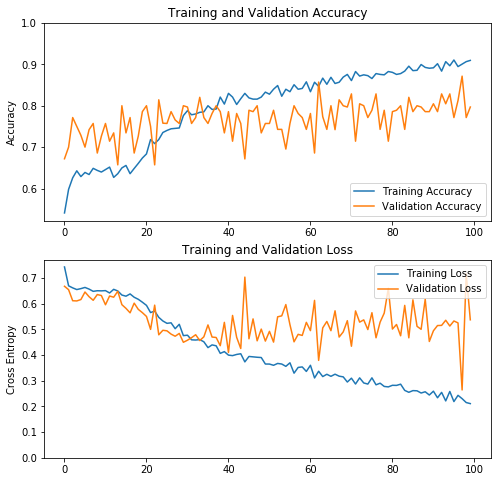

In [10]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [11]:
test_generator.reset()
pred=model.predict_generator(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

134/134 [==============================] - 1s 8ms/step


In [12]:
pred_bool = (pred >0.5)

In [13]:
predictions = pred_bool.astype(int)
results=pd.DataFrame(predictions, columns=columns)
results["External ID"]=test_generator.filenames
ordered_cols=["External ID"]+columns
results=results[ordered_cols]#To get the same column order
results.to_csv("mm_result.csv",index=False)

In [14]:
model.save('mm.h5')

In [15]:
test_generator.reset()
test_loss, test_acc = model.evaluate_generator(test_generator, steps = STEP_SIZE_TEST)
print('test acc:', test_acc)

test acc: 0.75
